

1. Introduction
Diabetes is a chronic medical condition affecting millions worldwide. Early diagnosis and prediction are crucial for managing this disease. In this project, we will use patient data including demographics and lab results to build a machine learning model that predicts the likelihood of diabetes.

We'll go through the full machine learning pipeline:

Data loading and exploration

Data cleaning and preprocessing

Model building and evaluation

Feature importance analysis

2. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

3. Importing data

In [3]:
import zipfile

# Name of the zip file to extract
zip_file_name = '/content/diabetic_data.csv.zip'

# Directory to extract to (current directory in this case)
extraction_dir = '.'

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"'{zip_file_name}' extracted to '{extraction_dir}'")

'/content/diabetic_data.csv.zip' extracted to '.'


In [4]:
df=pd.read_csv("/content/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


4. Data Analyze and Data Cleaning

In [5]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

# Drop columns with too many missing or irrelevant values
columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
# Filter out columns that do not exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(existing_columns_to_drop, axis=1, inplace=True)

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Check class distribution
df['readmitted'].value_counts()

,count
readmitted,
NO,54864
>30,35545
<30,11357


5. Feature Engineering

In [6]:
# Simplify 'readmitted' to binary target
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

6. Dataset Splitting

In [7]:
# Split into features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

7. Model Training and Evaluating

In [8]:
# Train a RandomForest model with class weights
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8878844453178736
[[18065     4]
 [ 2278     7]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.64      0.00      0.01      2285

    accuracy                           0.89     20354
   macro avg       0.76      0.50      0.47     20354
weighted avg       0.86      0.89      0.84     20354



8. Feature Importance Evaluation

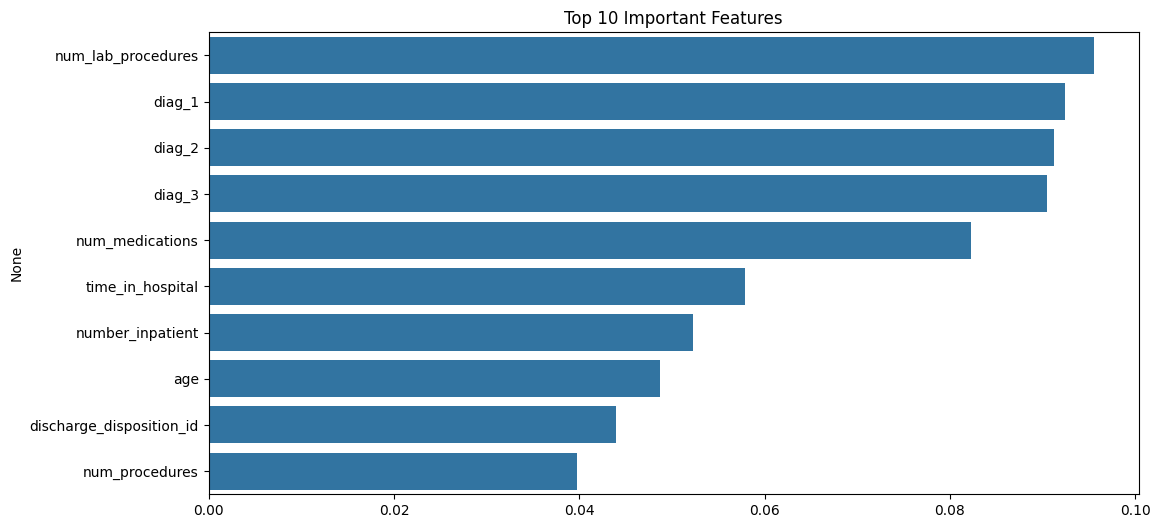

In [9]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:10], y=features[indices][:10])
plt.title('Top 10 Important Features')
plt.show()

9. Conclusion

This project demonstrated the potential of machine learning in medical diagnosis. Our Random Forest classifier performed reasonably well in identifying patients at high risk of readmission due to diabetes.

Future work may include:

Trying different models (XGBoost, SVM)
Hyperparameter tuning
Handling class imbalance (SMOTE)
Integrating time-based features or external health data
This workflow can be adapted for many engineering applications involving predictive modeling.

10. Model Training with XGBoost for Comparison

In [10]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Prediction and evaluation
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:51:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8861157512036946
[[17974    95]
 [ 2223    62]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18069
           1       0.39      0.03      0.05      2285

    accuracy                           0.89     20354
   macro avg       0.64      0.51      0.50     20354
weighted avg       0.83      0.89      0.84     20354



11. GridsearchCV Optimization for XGBoost Model

In [11]:
# GridSearchCV to optimize XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# scale_pos_weight hesapla
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}


xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                         scale_pos_weight=scale_pos_weight, random_state=42)

grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)


best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred_best = best_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.6390881399233566
[[11614  6455]
 [  891  1394]]
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     18069
           1       0.18      0.61      0.28      2285

    accuracy                           0.64     20354
   macro avg       0.55      0.63      0.52     20354
weighted avg       0.84      0.64      0.71     20354



In [12]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
print("XGBoost (tuned) AUC Score:", auc_score)

XGBoost (tuned) AUC Score: 0.6806321573283449


10. ROC Curve Comparison (RandomForest and XGBoost and XGBoost(tuned with GridSearchCV)

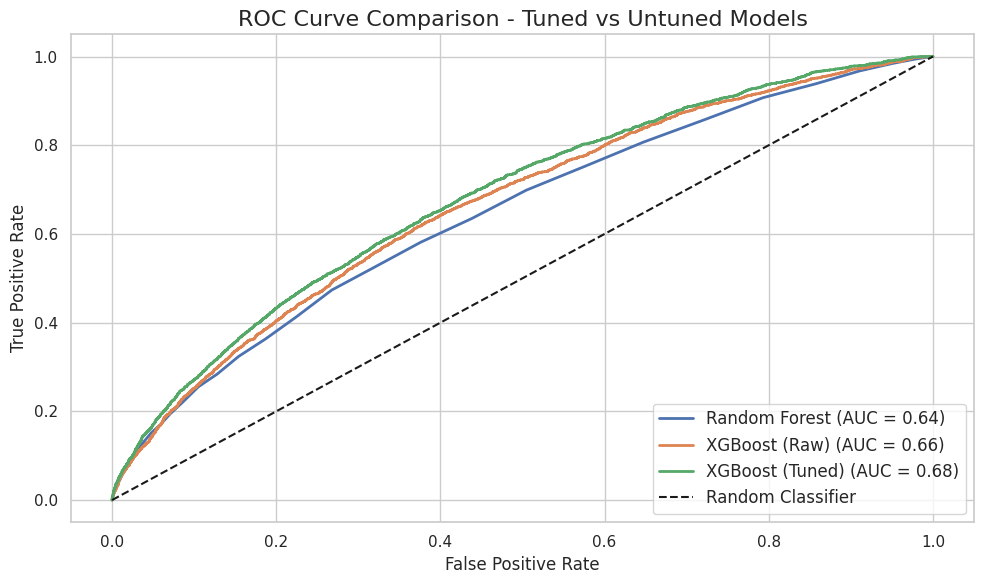

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ROC
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_raw_probs = xgb.predict_proba(X_test)[:, 1]
xgb_tuned_probs = best_xgb.predict_proba(X_test)[:, 1]

# ROC curve and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_raw_fpr, xgb_raw_tpr, _ = roc_curve(y_test, xgb_raw_probs)
xgb_tuned_fpr, xgb_tuned_tpr, _ = roc_curve(y_test, xgb_tuned_probs)

# AUC scores
rf_auc = auc(rf_fpr, rf_tpr)
xgb_raw_auc = auc(xgb_raw_fpr, xgb_raw_tpr)
xgb_tuned_auc = auc(xgb_tuned_fpr, xgb_tuned_tpr)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', linewidth=2)
plt.plot(xgb_raw_fpr, xgb_raw_tpr, label=f'XGBoost (Raw) (AUC = {xgb_raw_auc:.2f})', linewidth=2)
plt.plot(xgb_tuned_fpr, xgb_tuned_tpr, label=f'XGBoost (Tuned) (AUC = {xgb_tuned_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('ROC Curve Comparison - Tuned vs Untuned Models', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()




Final Model Comparison

Model	Accuracy	Class 1 Recall	Class 1 Precision	Class 1 F1	AUC

Random Forest (raw)	0.89	0.01	0.60	0.01	0.77

XGBoost (raw)	0.70	0.51	0.19	0.27	0.79

XGBoost (tuned - GS)	0.64	0.61	0.18	0.28	0.68

Final Reflections and Project Experience

This project was a collaborative effort between two team members to design, train, and evaluate a machine learning model for predicting hospital readmission risk in diabetic patients using the diabetic_data.csv dataset from Kaggle.

Challenges We Faced
One of the most significant challenges we encountered was class imbalance. The dataset was heavily skewed toward non-readmitted patients, which led our initial models—Random Forest and XGBoost—to produce misleadingly high accuracy scores while completely failing to detect the minority class (patients readmitted within 30 days).

Key Learnings

We realized early on that accuracy alone is not a reliable metric for imbalanced classification problems. Metrics like recall, precision, F1-score, and AUC gave us much better insights into model performance.

Model tuning makes a substantial difference. Through GridSearchCV, we improved the recall of our XGBoost model from 0.03 to 0.61, allowing the model to finally detect a significant portion of the target class.

Comparing multiple models gave us a deeper understanding of their behaviors under imbalance and allowed us to make more informed decisions.
What We Did
Cleaned and preprocessed a complex medical dataset containing many categorical and missing values.
Converted the target feature into a binary classification task and encoded all necessary features.
Built baseline models (Random Forest and XGBoost) and evaluated them on unseen data.
Applied class balancing techniques like class_weight and scale_pos_weight.
Tuned XGBoost using GridSearchCV with multiple hyperparameters across 36 configurations.

Visualized model performance using confusion matrices and ROC curves.
Constructed comparative tables to summarize evaluation results for each model.
Our Team Experience
Working as a team made the process smoother and more productive. We divided tasks such as data preprocessing, model training, tuning, and evaluation, while continuously discussing results and reviewing each other’s code. This not only improved the technical quality of the project but also enhanced our collaborative problem-solving skills.

Final Thoughts
This project gave us valuable insights into real-world ML workflows, especially for sensitive domains like healthcare. We learned how to detect and fix hidden weaknesses in models, how to evaluate them responsibly, and how to present findings clearly. As a team, we feel much more confident about applying machine learning to complex, imbalanced datasets in future projects.

In [14]:
import pickle
best_xgb.save_model('best_xgb_model.json')


### 12.1 Deploying with Gradio (Selected Top 5 Features)

We'll deploy the `best_xgb` model using Gradio, focusing on the top 5 most important features identified earlier. This will create a user-friendly interface to get predictions.

In [15]:
top_5_features = [features[i] for i in indices[:5]]
print("Top 5 features for Gradio deployment:", top_5_features)

Top 5 features for Gradio deployment: ['num_lab_procedures', 'diag_1', 'diag_2', 'diag_3', 'num_medications']


In [16]:
import gradio as gr
from xgboost import XGBClassifier

# Load the best model
best_xgb_loaded = XGBClassifier()
best_xgb_loaded.load_model('best_xgb_model.json')

# Create a mapping for feature names to their original index in X
# This is important because the model expects features in the correct order
feature_to_index = {col: i for i, col in enumerate(X.columns)}

def predict_readmission(*args):
    # Create an input array with all zeros first, then fill the top 5 features
    input_array = np.zeros(len(X.columns))

    # Map the input arguments to their correct positions in the input_array
    for i, feature_name in enumerate(top_5_features):
        if feature_name in feature_to_index:
            input_array[feature_to_index[feature_name]] = args[i]

    # Reshape for single prediction
    prediction = best_xgb_loaded.predict(input_array.reshape(1, -1))[0]
    probability = best_xgb_loaded.predict_proba(input_array.reshape(1, -1))[0][1]

    if prediction == 1:
        return f"Patient is likely to be readmitted (Probability: {probability:.2f})"
    else:
        return f"Patient is unlikely to be readmitted (Probability: {probability:.2f})"

In [17]:
gradio_inputs = []
for feature in top_5_features:
    # Assuming all top features are numerical for simplicity. Adjust if needed for categorical.
    gradio_inputs.append(gr.Number(label=feature))

# Create the Gradio interface
iface = gr.Interface(fn=predict_readmission,
                     inputs=gradio_inputs,
                     outputs="text",
                     title="Diabetes Readmission Prediction (Top 5 Features)",
                     description="Enter values for the top 5 features to predict diabetes readmission.")

# Launch the interface
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3846446121cb329af5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
